In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

import matplotlib.pyplot as plt

import numpy as np
from PIL import Image

In [2]:
os.getcwd()

'c:\\Users\\andyk\\OneDrive\\Documents\\GitHub\\yoga-pose-classification'

In [3]:
poses = ['downdog', "goddess", "mountain", "tree", "warrior1", "warrior2"]

In [ ]:
batch_size = 4
image_size = 512

In [ ]:
def removeCorruptedImages(path):
    for filename in os.listdir(path):
        try:
            print(filename)
            img = Image.open(os.path.join(path,filename))
            img.verify() 
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename)
            os.remove(os.path.join(path,filename))

def convert_to_jpg(path):
    for file in os.listdir(path):
        #print(path, file)
        img = Image.open(os.path.join(path, file))
        img = img.convert('RGB')
        file_name, file_ext = os.path.splitext(file)
        #print(file_name, file_ext)
        if file_ext != '.jpg':
            print(file_name)
            print(file_ext)
            img.save(os.path.join(path, f'{file_name}.jpg'))
            #os.remove(os.path.join(path, file_name))

        
    for file in os.listdir(path):
        if not file.endswith(".jpg"):
            os.remove(os.path.join(path, file))

base_path = "./dataset/poses/train/"

for pose in poses:
    path = os.path.join(base_path, pose)
    removeCorruptedImages(os.path.join(base_path, pose))
    convert_to_jpg(path)


In [4]:


transform = transforms.Compose(
[transforms.Resize((image_size, image_size)),
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train = torchvision.datasets.ImageFolder(root="dataset/poses/train/",
                                    transform=transform)
train_loader = torch.utils.data.DataLoader(train,
                                        batch_size=batch_size, shuffle=True,
                                        num_workers=4)

test = torchvision.datasets.ImageFolder(root="dataset/poses/test/",
                                    transform=transform)
test_loader = torch.utils.data.DataLoader(test,
                                        batch_size=batch_size, shuffle=True,
                                        num_workers=4)



In [10]:
print_outputs = False

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=7, stride=4, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=7, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=7, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(12)
        self.conv5 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(12)
        self.conv6 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(12)
        self.fc1 = nn.Linear(12*len(poses)*len(poses), len(poses))

    def forward(self, input):
        if print_output:
            print('FORWARD')
            print(input.shape)
        output = F.relu(self.bn1(self.conv1(input)))  
        if print_output:
            print(output.shape)    
        output = F.relu(self.bn2(self.conv2(output)))  
        if print_output:
            print(output.shape)     
        output = self.pool(output)     
        if print_output:
            print(output.shape)                      
        output = F.relu(self.bn4(self.conv4(output)))     
        if print_output:
            print(output.shape)   
        output = F.relu(self.bn5(self.conv5(output)))
        if print_output:
            print(output.shape)   
        output = output.view(-1, 12*len(poses)*len(poses))
        if print_output:
            print(output.shape)   
        output = self.fc1(output)
        if print_output:
            print(output.shape)   

        return output

# Instantiate a neural network model 
model = Network()

In [11]:

 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # print("outputs shape")
            # print(outputs.shape)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i%100 == 0:
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % poses[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % poses[predicted[j]] 
                              for j in range(batch_size)))

In [17]:
# Function to test what classes performed well
def testClasses():
    class_correct = list(0. for i in range(len(poses)))
    class_total = list(0. for i in range(len(poses)))
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(batch_size):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(number_of_labels):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

The model will be running on cpu device
[1,     1] loss: 0.002
[1,   101] loss: 0.178
[1,   201] loss: 0.175
[1,   301] loss: 0.162
[1,   401] loss: 0.152
[1,   501] loss: 0.145
[1,   601] loss: 0.136
For epoch 1 the test accuracy over the whole test set is 60 %
[2,     1] loss: 0.001
[2,   101] loss: 0.129
[2,   201] loss: 0.129
[2,   301] loss: 0.130
[2,   401] loss: 0.125
[2,   501] loss: 0.120
[2,   601] loss: 0.115
For epoch 2 the test accuracy over the whole test set is 69 %
[3,     1] loss: 0.001
[3,   101] loss: 0.106
[3,   201] loss: 0.098
[3,   301] loss: 0.103
[3,   401] loss: 0.105
[3,   501] loss: 0.104
[3,   601] loss: 0.095
For epoch 3 the test accuracy over the whole test set is 71 %
[4,     1] loss: 0.001
[4,   101] loss: 0.077
[4,   201] loss: 0.085
[4,   301] loss: 0.093
[4,   401] loss: 0.092
[4,   501] loss: 0.090
[4,   601] loss: 0.085
For epoch 4 the test accuracy over the whole test set is 77 %
[5,     1] loss: 0.001
[5,   101] loss: 0.071
[5,   201] loss: 0.067

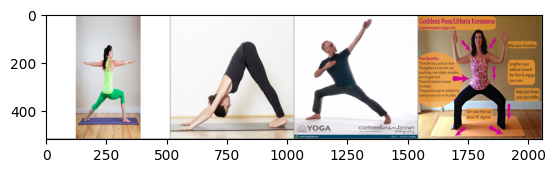

Real labels:  warrior2 downdog warrior2 goddess
Predicted:  warrior1 downdog downdog warrior2


NameError: name 'testClasses' is not defined

In [14]:
# Let's build our model
train(5)
print('Finished Training')

# # Test which classes performed well
# testModelAccuracy()

# Let's load the model we just created and test the accuracy per label
model = Network()
path = "myFirstModel.pth"
model.load_state_dict(torch.load(path))

# Test with batch of images
testBatch()